## ExMAS
> Equilibrium matching - expieriments for the paper

---
# ILP for various Objective functions

* how can we minimize PoA with ILP

In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching

In [4]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/game_toy.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData.requests = ExMAS.utils.load_requests('ExMAS/spinoffs/game/toy.csv')

In [5]:
params.shared_discount = 0.5
params.logger_level = "CRITICAL"
inData = ExMAS.main(inData, params)
inData = ExMAS.utils.prepare_PoA(inData)

In [6]:
OBJS = ['u_pax', 'u_veh','mean_ranking', 'mean_rel_ranking', 'mean_PoA', 'total_PoA','squared_PoA', 'min_prob','logsum_prob', 'worst']

In [7]:
descs = pd.Series(OBJS).to_frame(name='obj')
descs['description'] = ['minimize traveller disutility', 
                        'min vehicle hours', 
                        'rides of minimal mean ranking (for each traveller)', 
                        'as above yet relative ranking', 
                        'minimize mean PoA of selected rides', 
                       'as above but total',
                       'as above but total and squared', 
                       'maximize minimal probability (of least satisfied traveller) of selected rides', 
                       'maximize logsum of probabilities of travellers in selected rides',
                       'worst case for comparisons - maximize disutility']
descs

,obj,description
0,u_pax,minimize traveller disutility
1,u_veh,min vehicle hours
2,mean_ranking,rides of minimal mean ranking (for each travel...
3,mean_rel_ranking,as above yet relative ranking
4,mean_PoA,minimize mean PoA of selected rides
5,total_PoA,as above but total
6,squared_PoA,as above but total and squared
7,min_prob,maximize minimal probability (of least satisfi...
8,logsum_prob,maximize logsum of probabilities of travellers...
9,worst,worst case for comparisons - maximize disutility


functions

In [8]:
def test_obj_fun(inData, obj = 'u_pax', _plot = False):
    params.matching_obj = obj
    if "prob" in obj:
        params.minmax = 'max'
    else:
        params.minmax = 'min'
    if obj == 'worst':
        params.minmax = 'max'
        params.matching_obj = 'u_pax'   
    inData = matching(inData, params, plot = False)
    if _plot:
        m_solution = inData.sblts.m.copy()
        fig, ax = plt.subplots()
        for col in m_solution.columns:
            if inData.sblts.rides.loc[col].selected==0:
                m_solution[col] = m[col]
            else:
                m_solution[col] = m[col]*5

        ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
        ax.set_ylabel('rides')
        _ = ax.set_xlabel('trips')
        print('grey - feasible, black - selected')
    inData = ExMAS.utils.calc_solution_PoA(inData)
    ret = dict(PassUtility = inData.sblts.schedule.u_pax.sum(),
              VehKm = inData.sblts.schedule.u_veh.sum(),
              PoA_total = inData.sblts.schedule['mean_PoA'].sum(),
              PoA_std = inData.sblts.schedule['mean_PoA'].std(),
              ranking_mean = inData.sblts.schedule['mean_rel_ranking'].mean(),
              ranking_std = inData.sblts.schedule['mean_rel_ranking'].std())
    return pd.Series(ret)

def plot_results(ret):
    fig, ax = plt.subplots(2,3,figsize=(12,9), sharey = True)
    ax = ax.flatten()
    i=0
    for KPI in ret.index:
        ret.loc[KPI].plot(kind='barh',ax = ax[i])
        ax[i].set_title(KPI)
        i+=1
    ax[2].set_xlim(0,ret.loc['PoA_total'].values[:-1].max()*1.05)
    fig.suptitle('KPIs with various objective functions')
    ax[0].set_ylabel('objectives')
    ax[3].set_ylabel('objectives')  

In [9]:
ret=dict()
for obj in OBJS:
    ret[obj]=test_obj_fun(inData, obj = obj, _plot = False)
ret = pd.DataFrame(ret)


,u_pax,u_veh,mean_ranking,mean_rel_ranking,mean_PoA,total_PoA,squared_PoA,min_prob,logsum_prob,worst
PassUtility,26.804600,28.538400,26.968400,27.545775,27.636775,26.968400,27.636775,27.033800,26.968400,32.818500
VehKm,1890.000000,1829.000000,1893.000000,1871.000000,1868.000000,1893.000000,1868.000000,1913.000000,1893.000000,2115.000000
PoA_total,0.850000,1.916667,0.850000,0.766667,0.766667,0.850000,0.766667,1.000000,0.850000,7.200000
PoA_std,0.182802,0.318750,0.182802,0.183863,0.183863,0.182802,0.183863,0.218327,0.182802,0.557375
ranking_mean,0.433938,0.678241,0.450141,0.479702,0.501924,0.450141,0.501924,0.486382,0.450141,0.915909
ranking_std,0.296725,0.293502,0.290445,0.194467,0.170495,0.290445,0.170495,0.271263,0.290445,0.166684


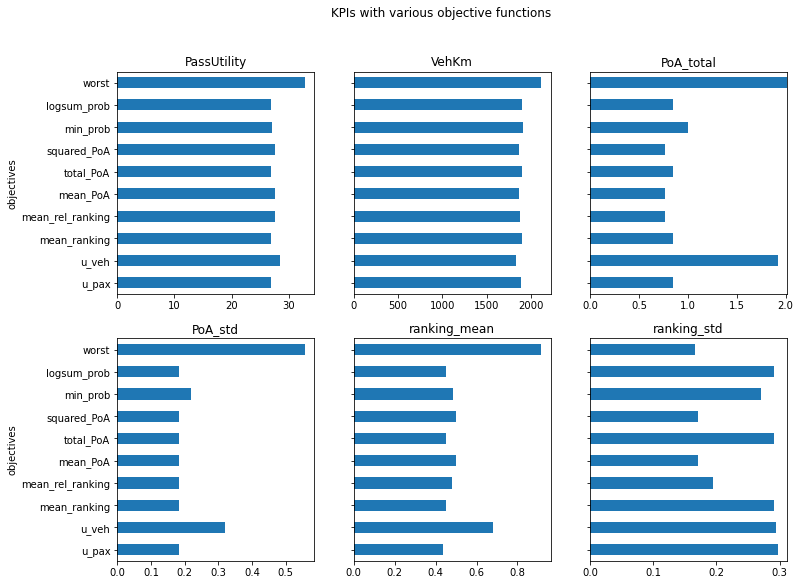

In [10]:
plot_results(ret)

# big

In [11]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/big.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [12]:
params.logger_level = 'INFO'
params.avg_speed
params.shared_discount = 0.3
params.avg_speed = 8
params.nP = 400
params.matching_obj = 'u_pax'
params.t0 = '17:00'
params.t0 = pd.to_datetime(params.t0)
params.VoT = 0.0035
params.WtS = 1.3
params.price = 1.5
params.horizon = -1
params.delay_value = 1.5
params.pax_delay = 10
params.max_degree = 5

In [13]:
inData = ExMAS.utils.generate_demand(inData, params)

In [14]:
inData = ExMAS.main(inData, params)

02-11-20 13:58:52-INFO-Initializing pairwise trip shareability between 400 and 400 trips.
02-11-20 13:58:52-INFO-creating combinations
02-11-20 13:58:52-INFO-159600	 nR*(nR-1)
02-11-20 13:59:00-INFO-Reduction of feasible pairs by 99.19%
02-11-20 13:59:00-INFO-Degree 2 	Completed
02-11-20 13:59:01-INFO-trips to extend at degree 2 : 2824
02-11-20 13:59:05-INFO-At degree 2 feasible extensions found out of 299 searched
02-11-20 13:59:05-INFO-Degree 3 	Completed
02-11-20 13:59:05-INFO-trips to extend at degree 3 : 299
02-11-20 13:59:06-INFO-At degree 3 feasible extensions found out of 27 searched
02-11-20 13:59:06-INFO-Degree 4 	Completed
02-11-20 13:59:06-INFO-trips to extend at degree 4 : 27
02-11-20 13:59:06-INFO-At degree 4 feasible extensions found out of 0 searched
02-11-20 13:59:06-INFO-Degree 5 	Completed
02-11-20 13:59:06-INFO-Max degree reached 5
02-11-20 13:59:06-INFO-Trips still possible to extend at degree 5 : 0
02-11-20 13:59:09-INFO-Matching 400 trips to 3550 rides in order t

In [15]:
inData = ExMAS.utils.prepare_PoA(inData)

In [16]:
for obj in OBJS:
    ret[obj]=test_obj_fun(inData, obj = obj, _plot = False)
ret = pd.DataFrame(ret)
ret

02-11-20 13:59:30-INFO-Matching 400 trips to 3550 rides in order to min u_pax
02-11-20 13:59:32-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,361 
reduced by matching to:                3,017
02-11-20 13:59:36-INFO-Matching 400 trips to 3550 rides in order to min u_veh
02-11-20 13:59:37-INFO-Problem solution: Optimal. 
Total costs for single trips:        216,705 
reduced by matching to:              154,766
02-11-20 13:59:41-INFO-Matching 400 trips to 3550 rides in order to min mean_ranking
02-11-20 13:59:43-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,753 
reduced by matching to:                  814
02-11-20 13:59:47-INFO-Matching 400 trips to 3550 rides in order to min mean_rel_ranking
02-11-20 13:59:48-INFO-Problem solution: Optimal. 
Total costs for single trips:            379 
reduced by matching to:                   68
02-11-20 13:59:52-INFO-Matching 400 trips to 3550 rides in order to min mean_PoA
02-11-20 13:59:53-INF

,u_pax,u_veh,mean_ranking,mean_rel_ranking,mean_PoA,total_PoA,squared_PoA,min_prob,logsum_prob,worst
PassUtility,3017.103250,3174.371800,3035.830637,3044.376712,3021.592400,3017.346875,3023.205975,3060.225625,3017.346875,3361.123500
VehKm,185411.000000,154766.000000,190594.000000,194785.000000,190030.000000,186149.000000,188913.000000,192563.000000,186149.000000,216705.000000
PoA_total,64.600000,137.858333,69.700000,69.933333,60.900000,64.600000,64.150000,114.150000,64.600000,457.500000
PoA_std,0.266657,0.430320,0.277168,0.290494,0.242429,0.267839,0.235644,0.538204,0.267839,0.673048
ranking_mean,0.383918,0.680495,0.364225,0.334626,0.362406,0.387508,0.386447,0.508321,0.387508,0.949197
ranking_std,0.284988,0.267225,0.268976,0.207916,0.245702,0.283551,0.258616,0.360352,0.283551,0.085526


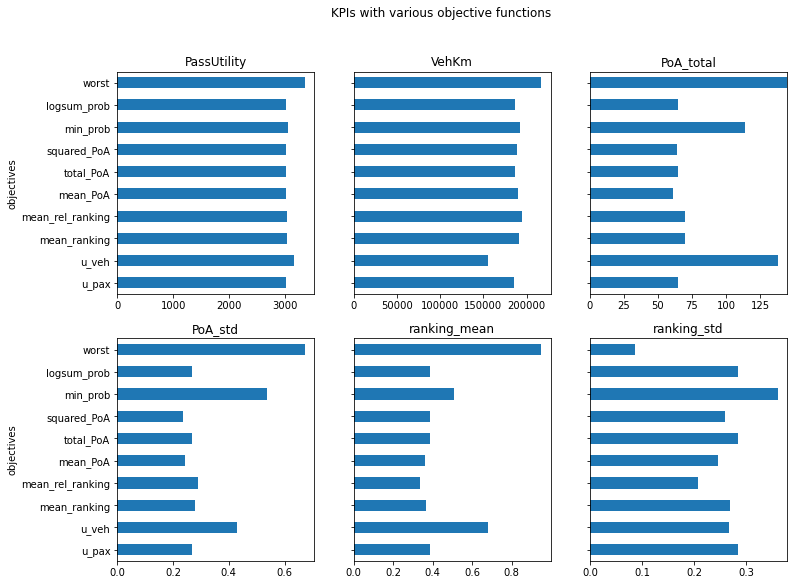

In [17]:
plot_results(ret)

---
(c) Rafał Kucharski, Delft, 2020